## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [147]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [148]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('Week_6_Data.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

Now, use `DictVectorizer` to turn train and validation into matrices:

In [149]:
from sklearn.model_selection import train_test_split

df['price']=np.log1p(df['price'])

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=42)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

del df_train['price']
del df_val['price']
del df_test['price']

In [150]:
from sklearn.feature_extraction import DictVectorizer

train_dict = df_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

val_dict = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(val_dict)

X_val = dv.transform(val_dict)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [151]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



/home/kenwu/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [152]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 10, random_state = 1, n_jobs = -1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

In [153]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

rmse(y_val, y_pred)

0.4642147735861472

What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [154]:
scores = []

for n in range(10, 200, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs = -1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse_score = rmse(y_val, y_pred)

    scores.append((n, rmse_score))

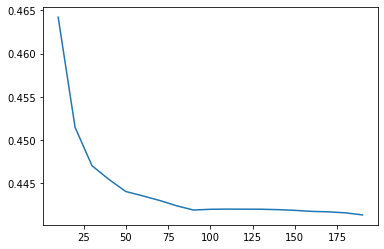

In [155]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
plt.plot(df_scores.n_estimators, df_scores.rmse)

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [160]:
scores = []
depths = [10, 15, 20, 25]

for depth in depths:
    rf = RandomForestRegressor(max_depth = depth, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse_score = rmse(y_val, y_pred)

    scores.append((depth, rmse_score))

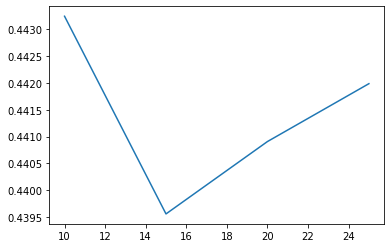

In [161]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'rmse'])
plt.plot(df_scores.max_depth, df_scores.rmse)

In [ ]:
df['price'] = np.log(df['price'])

from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['price']
y_val = df_val['price']
y_test = df_test['price']

del df_train['price']
del df_val['price']
del df_test['price']

/home/kenwu/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [171]:
rf = RandomForestRegressor(n_estimators = 10, max_depth = 20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

features = rf.feature_importances_
for i,v in enumerate(features):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.08056
Feature: 1, Score: 0.03043
Feature: 2, Score: 0.15022
Feature: 3, Score: 0.15689
Feature: 4, Score: 0.05447
Feature: 5, Score: 0.00023
Feature: 6, Score: 0.00130
Feature: 7, Score: 0.03425
Feature: 8, Score: 0.00132
Feature: 9, Score: 0.00009
Feature: 10, Score: 0.04375
Feature: 11, Score: 0.05058
Feature: 12, Score: 0.38621
Feature: 13, Score: 0.00503
Feature: 14, Score: 0.00469
0.3862101980140389


What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [174]:
import xgboost as xgb

features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

/home/kenwu/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Now change `eta` first to `0.1` and then to `0.01`

In [176]:
scores = []
etas = [0.3, 0.1, 0.01]

for eta in etas:
    xgb_params['eta'] = eta
    model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals = watchlist)
    y_pred = model.predict(dval)
    rmse_score = rmse(y_val, y_pred)
    scores.append((eta,rmse_score))

[0]	train-rmse:3.02797	val-rmse:3.02896
[1]	train-rmse:2.14703	val-rmse:2.14833
[2]	train-rmse:1.53987	val-rmse:1.54178
[3]	train-rmse:1.12690	val-rmse:1.12928
[4]	train-rmse:0.85280	val-rmse:0.85598
[5]	train-rmse:0.67679	val-rmse:0.68117
[6]	train-rmse:0.56976	val-rmse:0.57587
[7]	train-rmse:0.50760	val-rmse:0.51540
[8]	train-rmse:0.47255	val-rmse:0.48273
[9]	train-rmse:0.45351	val-rmse:0.46584
[10]	train-rmse:0.44209	val-rmse:0.45655
[11]	train-rmse:0.43532	val-rmse:0.45085
[12]	train-rmse:0.43181	val-rmse:0.44802
[13]	train-rmse:0.42942	val-rmse:0.44652
[14]	train-rmse:0.42680	val-rmse:0.44491
[15]	train-rmse:0.42463	val-rmse:0.44417
[16]	train-rmse:0.42335	val-rmse:0.44384
[17]	train-rmse:0.42189	val-rmse:0.44366
[18]	train-rmse:0.42057	val-rmse:0.44324
[19]	train-rmse:0.41966	val-rmse:0.44306
[20]	train-rmse:0.41758	val-rmse:0.44212
[21]	train-rmse:0.41672	val-rmse:0.44157
[22]	train-rmse:0.41578	val-rmse:0.44152
[23]	train-rmse:0.41429	val-rmse:0.44119
[24]	train-rmse:0.41364	va

In [180]:
print(scores)

[(0.3, 0.4411888392056691), (0.1, 0.4375679685473053), (0.01, 1.6345346205551055)]


Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* 0.01

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

